<a href="https://colab.research.google.com/github/sindhiya225/Traffic-Monitoring-Project/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark==3.4.0
!pip install pandas
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317124 sha256=1b89856e5bd41534686df8510c80c4671cd6556ad6beae7faa82bdb6d2adfd97
  Stored in directory: /root/.cache/pip/wheels/7f/71/c8/6ffadf411f7456a87d125cf3b7735f091f24e56ba54dd17852
Successfully built pyspark
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.1
    Uninstalling pyspark-3.5.1:
      Successfully uninstalled pyspark-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires pyspark[connect]~=3.5.1, but you have pyspark 3.4.0 which is incompatible.


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
spark = SparkSession.builder.appName("TrafficMonitoring").getOrCreate()

In [5]:
accidents_df = spark.read.csv("Accident_Information.csv", header=True, inferSchema=True)

# Show schema and sample data
accidents_df.printSchema()
accidents_df.show(5)

root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: integer (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_(District): string (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |--

In [6]:
import time
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType, IntegerType
from datetime import datetime
import random

# Define schema for streaming data
schema = StructType([
    StructField("vehicle_id", StringType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("speed", DoubleType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("weather", StringType(), True)
])

# Generate synthetic streaming data
def generate_traffic_data(n=100):
    data = []
    weather_conditions = ["Clear", "Rain", "Fog", "Snow"]
    for i in range(n):
        data.append((
            f"vehicle_{i}",
            datetime.now(),
            random.uniform(0, 120),  # Speed in km/h
            random.uniform(51.4, 51.6),  # Latitude (UK range)
            random.uniform(-0.2, 0.2),  # Longitude (UK range)
            random.choice(weather_conditions)
        ))
    return spark.createDataFrame(data, schema)

# Generate sample streaming data
stream_df = generate_traffic_data(100)
stream_df.show(5)

+----------+--------------------+------------------+-----------------+--------------------+-------+
|vehicle_id|           timestamp|             speed|         latitude|           longitude|weather|
+----------+--------------------+------------------+-----------------+--------------------+-------+
| vehicle_0|2025-10-22 06:01:...| 92.54309749699918|51.50726355442672|-0.02360393805725297|   Snow|
| vehicle_1|2025-10-22 06:01:...| 68.65671734298263|51.44540522633086|0.001961698232308212|    Fog|
| vehicle_2|2025-10-22 06:01:...| 71.19901325291326|51.56993000415359|-0.04863905348038561|  Clear|
| vehicle_3|2025-10-22 06:01:...|109.15447129153205| 51.4797907268958| 0.14969218153449043|  Clear|
| vehicle_4|2025-10-22 06:01:...|   9.9474432224899|51.45537380841122| -0.1843665400592685|   Snow|
+----------+--------------------+------------------+-----------------+--------------------+-------+
only showing top 5 rows



In [7]:
# Clean accident data
clean_accidents_df = accidents_df.dropna(subset=["Speed_limit", "Weather_conditions", "Road_Type", "Accident_Severity"])
clean_accidents_df = clean_accidents_df.select(
    col("Speed_limit").cast("double"),
    col("Weather_conditions"),
    col("Road_Type"),
    col("Accident_Severity"),
    col("Longitude").cast("double"),
    col("Latitude").cast("double")
)

# Aggregate by region (approximate using Latitude/Longitude bins)
agg_df = clean_accidents_df.groupBy(
    (col("Latitude").cast("int") * 100).alias("lat_bin"),
    (col("Longitude").cast("int") * 100).alias("lon_bin")
).agg(
    avg("Speed_limit").alias("avg_speed"),
    count("*").alias("accident_count")
)

# Show aggregated data
agg_df.show(5)

# Save to Delta table (simulated in Colab as Parquet)
agg_df.write.mode("overwrite").parquet("/content/delta_table")

+-------+-------+-----------------+--------------+
|lat_bin|lon_bin|        avg_speed|accident_count|
+-------+-------+-----------------+--------------+
|   5100|      0|30.83163097199341|         15175|
+-------+-------+-----------------+--------------+



In [8]:
# Filter low-speed events (congestion detection)
congestion_df = stream_df.filter(col("speed") < 20.0)

# Show potential congestion events
congestion_df.show(5)

+----------+--------------------+------------------+------------------+--------------------+-------+
|vehicle_id|           timestamp|             speed|          latitude|           longitude|weather|
+----------+--------------------+------------------+------------------+--------------------+-------+
| vehicle_4|2025-10-22 06:01:...|   9.9474432224899| 51.45537380841122| -0.1843665400592685|   Snow|
| vehicle_6|2025-10-22 06:01:...|  6.39108355781385| 51.48294113851415|-0.00818692546073...|  Clear|
| vehicle_8|2025-10-22 06:01:...|3.6454397788311166|  51.4063874901296| 0.11450072281599927|  Clear|
|vehicle_17|2025-10-22 06:01:...|16.377174464488633|51.435641581655545| 0.06300030056784522|  Clear|
|vehicle_20|2025-10-22 06:01:...| 6.853277326348497| 51.58818651649425|0.033672450247207164|   Snow|
+----------+--------------------+------------------+------------------+--------------------+-------+
only showing top 5 rows



In [9]:
# Generate alerts for congestion
alerts = congestion_df.select("vehicle_id", "speed", "latitude", "longitude", "weather")
alerts.show()

+----------+-------------------+------------------+--------------------+-------+
|vehicle_id|              speed|          latitude|           longitude|weather|
+----------+-------------------+------------------+--------------------+-------+
| vehicle_4|    9.9474432224899| 51.45537380841122| -0.1843665400592685|   Snow|
| vehicle_6|   6.39108355781385| 51.48294113851415|-0.00818692546073...|  Clear|
| vehicle_8| 3.6454397788311166|  51.4063874901296| 0.11450072281599927|  Clear|
|vehicle_17| 16.377174464488633|51.435641581655545| 0.06300030056784522|  Clear|
|vehicle_20|  6.853277326348497| 51.58818651649425|0.033672450247207164|   Snow|
|vehicle_29| 1.7297567449552087|51.512353396526365|-0.12352485951443137|  Clear|
|vehicle_36|  4.943973684985381|51.403982679686074|-0.05442125629329225|    Fog|
|vehicle_42| 16.824462991420134|51.448735890141535|0.023854505671342174|   Snow|
|vehicle_43|   4.91686803478375|51.467805915170956| 0.15807225376107742|    Fog|
|vehicle_45| 1.3523938269453

In [10]:
from pyspark.sql.functions import col, when

# Map string Accident_Severity to numeric values
clean_accidents_df = clean_accidents_df.withColumn(
    "severity_numeric",
    when(col("Accident_Severity") == "Fatal", 1)
    .when(col("Accident_Severity") == "Serious", 2)
    .when(col("Accident_Severity") == "Slight", 3)
    .otherwise(3)
)

# Create binary label (1 for Fatal/Serious, 0 for Slight)
ml_df = clean_accidents_df.withColumn(
    "label",
    when(col("severity_numeric").isin([1, 2]), 1).otherwise(0)
)

# Verify label distribution
ml_df.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 1584|
|    0|13591|
+-----+-----+



In [11]:
from pyspark.sql.functions import col

# Filter severe and non-severe accidents
severe_df = ml_df.filter(col("label") == 1)
non_severe_df = ml_df.filter(col("label") == 0)

# Check counts
severe_count = severe_df.count()
non_severe_count = non_severe_df.count()
print(f"Severe accidents: {severe_count}, Non-severe accidents: {non_severe_count}")

# Calculate oversampling fraction to match non-severe count
target_count = non_severe_count  # Aim for 45091 severe samples
oversample_fraction = float(target_count / severe_count)  # e.g., 45091 / 6898 ≈ 6.54
print(f"Oversample fraction: {oversample_fraction}")

# Oversample severe accidents
severe_df = severe_df.sample(withReplacement=True, fraction=oversample_fraction, seed=42)

# Union to create balanced dataset
balanced_df = severe_df.limit(target_count).union(non_severe_df)

# Verify balanced label distribution
balanced_df.groupBy("label").count().show()

Severe accidents: 1584, Non-severe accidents: 13591
Oversample fraction: 8.580176767676768
+-----+-----+
|label|count|
+-----+-----+
|    1|13591|
|    0|13591|
+-----+-----+



In [12]:
from pyspark.sql.functions import col

# Filter severe and non-severe accidents
severe_df = ml_df.filter(col("label") == 1)
non_severe_df = ml_df.filter(col("label") == 0)

# Check counts
severe_count = severe_df.count()
non_severe_count = non_severe_df.count()
print(f"Severe accidents: {severe_count}, Non-severe accidents: {non_severe_count}")

# Use smaller target count for Colab
target_count = 5000  # 5000 per class = 10,000 total rows
oversample_fraction = float(target_count / severe_count)  # e.g., 5000 / 6898 ≈ 0.725
print(f"Oversample fraction: {oversample_fraction}")

# Oversample severe accidents
severe_df = severe_df.sample(withReplacement=True, fraction=oversample_fraction, seed=42)

# Union to create balanced dataset
balanced_df = severe_df.limit(target_count).union(non_severe_df.limit(target_count))

# Verify balanced label distribution
balanced_df.groupBy("label").count().show()

Severe accidents: 1584, Non-severe accidents: 13591
Oversample fraction: 3.1565656565656566
+-----+-----+
|label|count|
+-----+-----+
|    1| 5000|
|    0| 5000|
+-----+-----+



In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, when

# Assume balanced_df is already created from optimized_balance_dataset.py
ml_df = balanced_df.withColumn(
    "weather_code",
    when(col("Weather_conditions") == "Fine no high winds", 1)
    .when(col("Weather_conditions") == "Raining no high winds", 2)
    .otherwise(3)
)

# Clean features
ml_df = ml_df.dropna(subset=["Speed_limit", "weather_code", "Latitude", "Longitude"])
ml_df = ml_df.filter(
    (col("Speed_limit").isNotNull()) &
    (col("Latitude").isNotNull()) &
    (col("Longitude").isNotNull()) &
    (col("weather_code").isNotNull())
)

# Verify label distribution
ml_df.groupBy("label").count().show()

# Feature vector
assembler = VectorAssembler(
    inputCols=["Speed_limit", "weather_code", "Latitude", "Longitude"],
    outputCol="features"
)
ml_data = assembler.transform(ml_df).select("features", "label")

# Split data
train_data, test_data = ml_data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=10,
    maxDepth=5,
    seed=42
)
model = rf.fit(train_data)

# Make predictions
predictions = model.transform(test_data)
predictions.select("features", "label", "rawPrediction", "probability", "prediction").show(5)

# Evaluate model
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)
accuracy = evaluator.evaluate(predictions)
print(f"Model AUC: {accuracy}")

# Save model correctly
model.write().save("/content/rf_model")

+-----+-----+
|label|count|
+-----+-----+
|    1| 5000|
|    0| 5000|
+-----+-----+

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[20.0,1.0,51.4868...|    1|[4.85136559679277...|[0.48513655967927...|       1.0|
|[20.0,1.0,51.4991...|    1|[4.85136559679277...|[0.48513655967927...|       1.0|
|[20.0,1.0,51.4991...|    1|[4.85136559679277...|[0.48513655967927...|       1.0|
|[20.0,1.0,51.5192...|    1|[4.85136559679277...|[0.48513655967927...|       1.0|
|[20.0,2.0,51.5452...|    1|[0.12356677365529...|[0.01235667736552...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Model AUC: 0.7997511004094249


In [14]:
from pyspark.ml.classification import RandomForestClassificationModel

# Load the saved model
loaded_model = RandomForestClassificationModel.load("/content/rf_model")

# Test prediction
test_predictions = loaded_model.transform(test_data)
test_predictions.select("features", "label", "prediction").show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[20.0,1.0,51.4868...|    1|       1.0|
|[20.0,1.0,51.4991...|    1|       1.0|
|[20.0,1.0,51.4991...|    1|       1.0|
|[20.0,1.0,51.5192...|    1|       1.0|
|[20.0,2.0,51.5452...|    1|       1.0|
+--------------------+-----+----------+
only showing top 5 rows



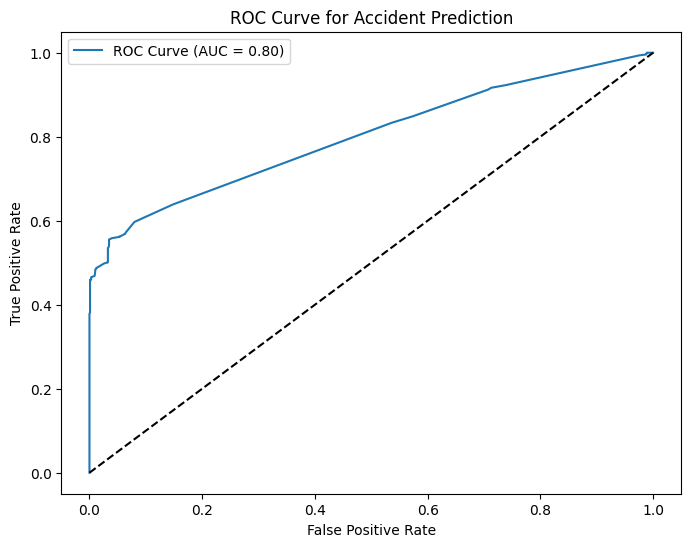

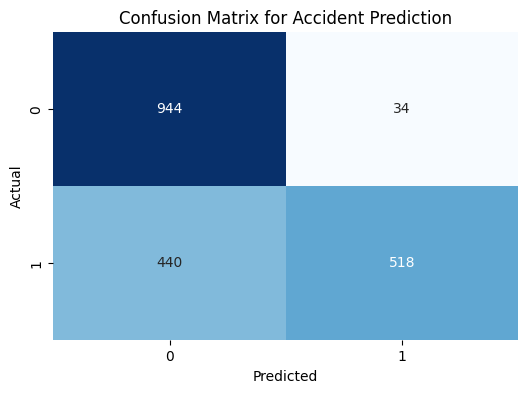

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Convert predictions to Pandas
pred_pd = predictions.select("probability", "label", "prediction").toPandas()
pred_pd["probability"] = pred_pd["probability"].apply(lambda x: x[1])

# Plot ROC curve
fpr, tpr, _ = roc_curve(pred_pd["label"], pred_pd["probability"])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Accident Prediction")
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Accident Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
from pyspark.sql.functions import col, when

# Clean data
clean_accidents_df = accidents_df.dropna(subset=["Speed_limit", "Weather_conditions", "Accident_Severity", "Latitude", "Longitude"])
clean_accidents_df = clean_accidents_df.select(
    col("Speed_limit").cast("double"),
    col("Weather_conditions"),
    col("Accident_Severity"),
    col("Latitude").cast("double"),
    col("Longitude").cast("double")
)

# Map string Accident_Severity to numeric values
clean_accidents_df = clean_accidents_df.withColumn(
    "severity_numeric",
    when(col("Accident_Severity") == "Fatal", 1)
    .when(col("Accident_Severity") == "Serious", 2)
    .when(col("Accident_Severity") == "Slight", 3)
    .otherwise(3)
)

# Create binary label
ml_df = clean_accidents_df.withColumn(
    "label",
    when(col("severity_numeric").isin([1, 2]), 1).otherwise(0)
)

# Balance dataset
severe_df = ml_df.filter(col("label") == 1)
non_severe_df = ml_df.filter(col("label") == 0)
severe_count = severe_df.count()
non_severe_count = non_severe_df.count()
print(f"Severe accidents: {severe_count}, Non-severe accidents: {non_severe_count}")

target_count = 5000  # 5000 per class
oversample_fraction = float(target_count / severe_count)
severe_df = severe_df.sample(withReplacement=True, fraction=oversample_fraction, seed=42)
balanced_df = severe_df.limit(target_count).union(non_severe_df.limit(target_count))

# Save to Parquet (simulating Delta Table)
balanced_df.write.mode("overwrite").parquet("/content/delta_table")

# Verify
balanced_df.groupBy("label").count().show()

Severe accidents: 1584, Non-severe accidents: 13591
+-----+-----+
|label|count|
+-----+-----+
|    1| 5000|
|    0| 5000|
+-----+-----+



In [17]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, DoubleType
from datetime import datetime
import random

# Define schema for streaming data
schema = StructType([
    StructField("vehicle_id", StringType(), True),
    StructField("timestamp", TimestampType(), True),
    StructField("speed", DoubleType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("weather", StringType(), True)
])

# Generate synthetic streaming data
def generate_traffic_data(n=100):
    data = []
    weather_conditions = ["Clear", "Rain", "Fog", "Snow"]
    for i in range(n):
        data.append((
            f"vehicle_{i}",
            datetime.now(),
            random.uniform(0, 120),
            random.uniform(51.4, 51.6),
            random.uniform(-0.2, 0.2),
            random.choice(weather_conditions)
        ))
    return spark.createDataFrame(data, schema)

# Generate streaming data
stream_df = generate_traffic_data(100)

# Detect congestion (low-speed clusters)
congestion_df = stream_df.filter(col("speed") < 20.0)

# Generate alerts
alerts = congestion_df.select("vehicle_id", "speed", "latitude", "longitude", "weather")
alerts.show(5)

# Save streaming data to Parquet
alerts.write.mode("append").parquet("/content/streaming_data")

+----------+------------------+-----------------+--------------------+-------+
|vehicle_id|             speed|         latitude|           longitude|weather|
+----------+------------------+-----------------+--------------------+-------+
| vehicle_7|3.4110313189764296|51.46169103489659| 0.11354811020941669|  Clear|
| vehicle_8|17.797884429079232|51.44138486457504| 0.15384063727116493|   Rain|
|vehicle_10| 13.01238008228204|51.51094511770582| 0.18667406418463883|    Fog|
|vehicle_11|2.3826433620180643|51.53131349972334| 0.12001432275054053|  Clear|
|vehicle_14|13.718722165103166|51.56567586915037|-0.19228083719305428|    Fog|
+----------+------------------+-----------------+--------------------+-------+
only showing top 5 rows



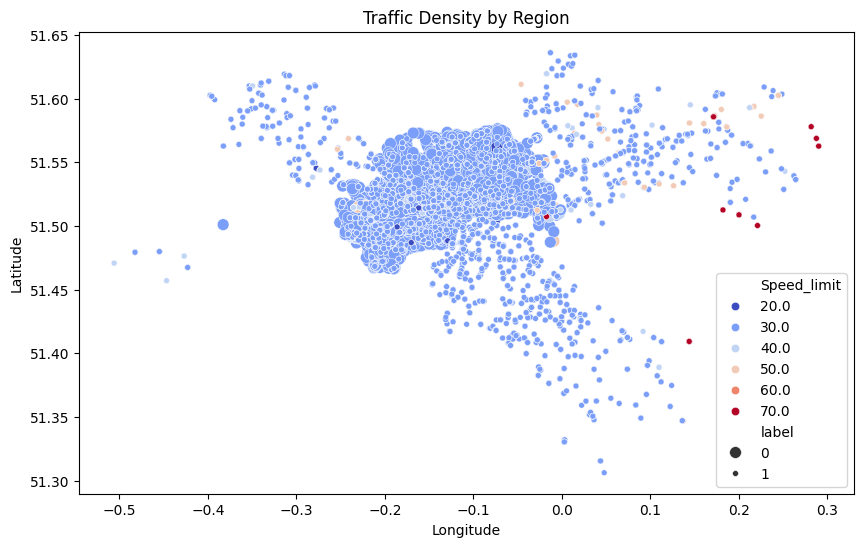

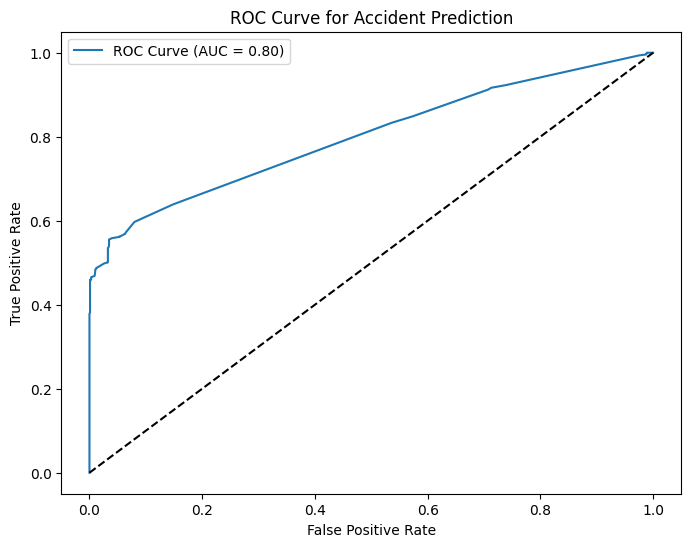

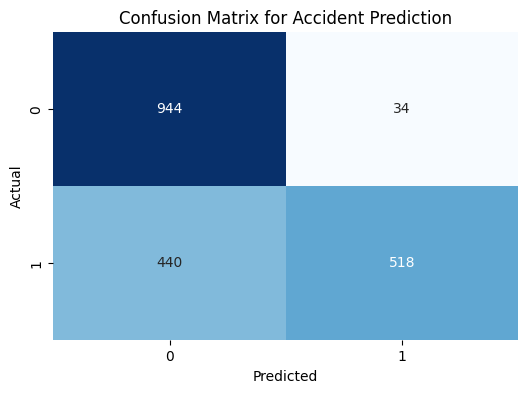

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Traffic density plot (from ETL pipeline)
agg_df = spark.read.parquet("/content/delta_table")
agg_pd = agg_df.toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(data=agg_pd, x="Longitude", y="Latitude", size="label", hue="Speed_limit", palette="coolwarm")
plt.title("Traffic Density by Region")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# ROC curve
pred_pd = predictions.select("probability", "label", "prediction").toPandas()
pred_pd["probability"] = pred_pd["probability"].apply(lambda x: x[1])
fpr, tpr, _ = roc_curve(pred_pd["label"], pred_pd["probability"])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Accident Prediction")
plt.legend()
plt.show()

# Confusion matrix
cm = confusion_matrix(pred_pd["label"], pred_pd["prediction"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Accident Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()